# 1 GNN

In [ ]:
# Packages
import numpy as np
import pandas as pd
from zipfile import ZipFile
import networkx as nx
from fastprogress import master_bar, progress_bar
from networkx.algorithms import centrality

from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import multiprocessing
from collections import defaultdict
import random as rd
rd.seed(1)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

StellarGraph

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  !pip install -q stellargraph[demos]

     |████████████████████████████████| 435 kB 3.1 MB/s 
     |████████████████████████████████| 407 kB 50.0 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 


In [ ]:
from stellargraph import StellarGraph
import stellargraph as sg

In [ ]:
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH_FOLDER = '/content/gdrive/MyDrive/Colab Notebooks/graph_based_recommendation_system'
%cd {PATH_FOLDER}

/content/gdrive/.shortcut-targets-by-id/1Qu7UOLxDtaHg6JbrDo0q-3e4ePr807CH/graph_based_recommendation_system


In [ ]:
%ls

data/                  figures/   GraphCentralities.ipynb  project_proposal.pdf
DataExploration.ipynb  GNN.ipynb  project_proposal.docx    README.md


## 1.1 Load data

### 1.1.1 Load DataFrames

In [ ]:
# Loading dataset from .zip file
path_dataset = "data/dataset.zip"

with ZipFile(path_dataset, 'r') as zip_ref:
    all_path = zip_ref.namelist()
    print('Paths: ', all_path)
    
    df_anime = pd.read_csv(zip_ref.open(all_path[0]))
    df_rating = pd.read_csv(zip_ref.open(all_path[1]))

Paths:  ['anime.csv', 'rating.csv']


Elimination of rows that have Nan values

In [ ]:
#df_anime.dropna(inplace=True)
df_rating.dropna(inplace=True)

Elimination of all rating values whose anime doesn't have a description in file 'anime.csv'

In [ ]:
for i in df_rating.anime_id.unique():
  if df_anime[df_anime['anime_id'] == i].empty:
    df_rating = df_rating[df_rating['anime_id'] != i]

Elimination of all user-item interactions when a rate has not been given (rating = -1)

In [ ]:
# number of user that have seen an anime, but didn't give a rate (meaning rating = -1)
df_rating[df_rating['rating'] == -1].rating.value_counts()

-1    1476488
Name: rating, dtype: int64

In [ ]:
# new dataframe without user-item intercations with rating = -1
new_df_rating = df_rating[df_rating['rating'] != -1]
assert(new_df_rating.shape[0] == df_rating.shape[0] - 1476488)

df_rating = new_df_rating
del new_df_rating

Number of possible nodes and edges after the pre-processing phase

In [ ]:
num_users = len(df_rating['user_id'].unique())
num_items = len(df_rating['anime_id'].unique())
num_nodes = num_users + num_items

print('Number of nodes: ', num_nodes)
print('Number of edges: ', df_rating.shape[0])

Number of nodes:  79526
Number of edges:  6337239


### 1.1.2 Load graph

In [ ]:
G = nx.readwrite.edgelist.read_weighted_edgelist('./data/graph.edgelist')

In [ ]:
# Add user node type
for i in df_rating.user_id.unique():
  attrs = {'user_' + str(i): {'node_type':'user'}}
  nx.set_node_attributes(G, attrs)

# Add anime node type
for i in df_rating.anime_id.unique():
  attrs = {'anime_' + str(i): {'node_type':'anime'}}
  nx.set_node_attributes(G, attrs)

## 1.2 Parameters

In [ ]:
# k = nodes sample out of the total amount
# otherwise the gnn training requires too much time
k = 15000

batch_size = 200
epochs = 20

train_size = 0.7
val_size = 0.25
test_size = 0.3

seed = 11

## 1.3. Update DataFrames
To correctly use HinSage algorithm given by StellarGraph library, every node must have a set of features. Therefore the creation bellow of two specific dataframes.

In [ ]:
rd.seed(seed)
k_nodes = rd.sample(list(G.nodes()), k=k)
subG = G.subgraph(k_nodes)

userList = [n for n,d in subG.nodes(data=True) if d['node_type'] == 'user']
animeList = [n for n,d in subG.nodes(data=True) if d['node_type'] == 'anime']

num_users = len(set(userList))
num_items = len(set(animeList))

print('Number of users: ', num_users)
print('Number of animes: ', num_items)
print()
print('[Info] Number of NODES: ', num_users + num_items)
print('[Info] Number of EDGES: ', len(subG.edges()))

Number of users:  13176
Number of animes:  1824

[Info] Number of NODES:  15000
[Info] Number of EDGES:  204188


Stellar Graph

In [ ]:
data_user = defaultdict()
data_anime = defaultdict()


# --------- Users features ------------
# -------------------------------------
for i in userList:
  avg_rating = np.mean([e[2]['weight'] for e in G.edges(i, data=True)])
  data_user[i] = avg_rating

user_features = pd.DataFrame.from_dict(data_user, orient='index', columns=['avg_rating'])
  

# --------- Anime features ------------
# -------------------------------------
for i in animeList:
  # RATING
  code = int(i[6:])
  rating = df_anime[df_anime['anime_id']==code].rating.to_string(index=False)
  if rating != 'NaN':
    rating = float(rating[1:])
  else:
    rating = 0.0

  # MEMBERS
  members = int(df_anime[df_anime['anime_id']==code].members.to_string(index=False)[1:])
  
  # FEATURES
  data_anime[i] = [rating, members]
  

anime_features = pd.DataFrame.from_dict(data_anime, orient='index', columns=['rating', 'members'])

In [ ]:
user_features.head()

,avg_rating
user_6724,8.328063
user_55387,6.917431
user_45219,8.500000
user_31703,9.000000
user_39927,8.400000


In [ ]:
anime_features.head()

,rating,members
anime_18047,5.12,170
anime_1869,7.10,11447
anime_1205,7.33,15565
anime_9287,6.38,1492
anime_4664,7.43,6677


In [ ]:
g = StellarGraph.from_networkx(subG, node_type_attr='node_type', edge_weight_attr='weight', edge_type_default='rating',
                               node_features={'user': user_features, 'anime': anime_features})
print(g.info())

StellarGraph: Undirected multigraph
 Nodes: 15000, Edges: 204188

 Node types:
  user: [13176]
    Features: float32 vector, length 1
    Edge types: user-rating->anime
  anime: [1824]
    Features: float32 vector, length 2
    Edge types: anime-rating->user

 Edge types:
    anime-rating->user: [204188]
        Weights: range=[1, 10], mean=7.73572, std=1.58237
        Features: none


## 1.4 Link prediction

In [ ]:
users = []
anime = []
rating = []
for e in list(subG.edges(data=True)):
  n1 = e[0]
  n2 = e[1]
  if n1[:5] == 'anime':
    a = n1
    u = n2
  else:
    a = n2
    u = n1 

  r = e[2]['weight']

  users.append(u) 
  anime.append(a)
  rating.append(r) 

E = pd.DataFrame({'user_id':users, 'anime_id':anime, 'rating':rating})

In [ ]:
E.head()

,user_id,anime_id,rating
0,user_6724,anime_6,9.0
1,user_6724,anime_32,10.0
2,user_6724,anime_71,9.0
3,user_6724,anime_150,8.0
4,user_6724,anime_192,7.0


Train, validation and test sets

In [ ]:
#E = pd.read_csv('./data/graph.edgelist', names=['user_id', 'anime_id', 'rating'], delimiter=' ')

In [ ]:
edges_train_val, edges_test = model_selection.train_test_split(
    E, train_size=train_size, test_size=test_size, random_state=seed
)

edges_train, edges_val = model_selection.train_test_split(
    edges_train_val, test_size=val_size, random_state=seed
)

In [ ]:
edgelist_train = edges_train.iloc[:, :2].to_numpy()
edgelist_val = edges_val.iloc[:, :2].to_numpy()
edgelist_test = edges_test.iloc[:, :2].to_numpy()

labels_train = edges_train['rating'].to_numpy()
labels_val= edges_val['rating'].to_numpy()
labels_test = edges_test['rating'].to_numpy()

In [ ]:
#little check
num_edges = len(edgelist_train) + len(edgelist_val) + len(edgelist_test)
print('Tot num of edges: ', num_edges)
print('Edges in the graph: ', len(E))

Tot num of edges:  204188
Edges in the graph:  204188


Number of layers/iterations in the HinSAGE model

In [ ]:
num_samples = [8, 4]

Graph

In [ ]:
generator = HinSAGELinkGenerator(
    g, batch_size, num_samples, head_node_types=["user", "anime"]
)
train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)
val_gen = generator.flow(edgelist_val, labels_val)

In [ ]:
test_gen = generator.flow(edgelist_test, labels_test)

In [ ]:
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('user', [2]),
 ('anime', [3]),
 ('anime', [4]),
 ('user', [5]),
 ('user', []),
 ('anime', [])]

In [ ]:
generator.schema.schema

{'anime': [EdgeType(n1='anime', rel='rating', n2='user')],
 'user': [EdgeType(n1='user', rel='rating', n2='anime')]}

In [ ]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
)

In [ ]:
# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.in_out_tensors()

In [ ]:
# Final estimator layer
score_prediction = link_regression(edge_embedding_method="concat")(x_out)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


In [ ]:
import tensorflow.keras.backend as K


def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 8, 2)]       0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 32, 2)]      0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1, 1)]       0                                            
____________________________________________________________________________________________

In [ ]:
# Specify the number of workers to use for model training
num_workers = 4

Evaluate the fresh (untrained) model on the test set (for reference):

In [ ]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

307/307 [==============================] - 47s 151ms/step - loss: 57.9475 - root_mean_square_error: 7.6119 - mean_absolute_error: 7.4409
Untrained model's Test Evaluation:
	loss: 57.9475
	root_mean_square_error: 7.6119
	mean_absolute_error: 7.4409


**Training**

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

Epoch 1/20
536/536 [==============================] - 114s 208ms/step - loss: 4.2420 - root_mean_square_error: 1.8264 - mean_absolute_error: 1.4951 - val_loss: 2.3246 - val_root_mean_square_error: 1.5214 - val_mean_absolute_error: 1.1889
Epoch 2/20
536/536 [==============================] - 111s 207ms/step - loss: 2.3814 - root_mean_square_error: 1.5402 - mean_absolute_error: 1.2035 - val_loss: 2.3265 - val_root_mean_square_error: 1.5221 - val_mean_absolute_error: 1.1927
Epoch 3/20
536/536 [==============================] - 125s 233ms/step - loss: 2.3824 - root_mean_square_error: 1.5404 - mean_absolute_error: 1.2040 - val_loss: 2.3212 - val_root_mean_square_error: 1.5204 - val_mean_absolute_error: 1.1890
Epoch 4/20
536/536 [==============================] - 112s 209ms/step - loss: 2.3822 - root_mean_square_error: 1.5407 - mean_absolute_error: 1.2038 - val_loss: 2.3211 - val_root_mean_square_error: 1.5204 - val_mean_absolute_error: 1.1878
Epoch 5/20
536/536 [============================

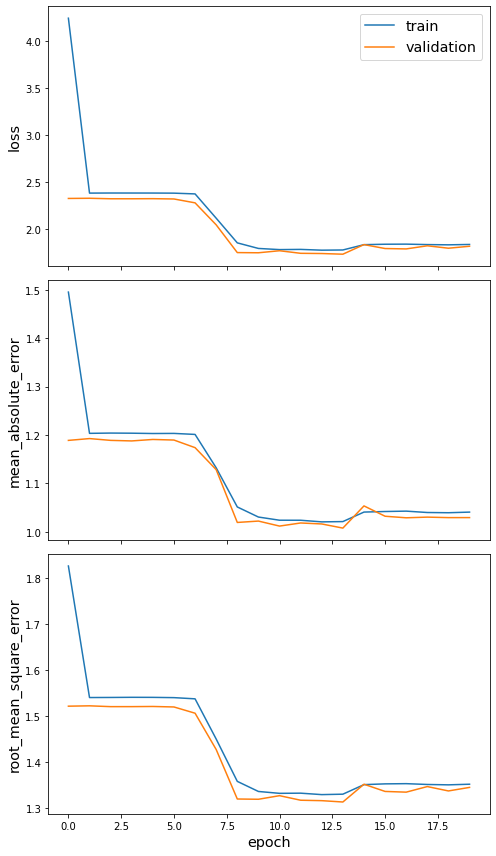

In [ ]:
sg.utils.plot_history(history)

Evaluate the trained model on test user-anime rankings:

In [ ]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

307/307 [==============================] - 48s 154ms/step - loss: 1.8259 - root_mean_square_error: 1.3473 - mean_absolute_error: 1.0320
Test Evaluation:
	loss: 1.8259
	root_mean_square_error: 1.3473
	mean_absolute_error: 1.0320


Compare the predicted test rankings with “mean baseline” rankings

In [ ]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.5789169875597904
	mean_absolute_error =  1.2444510612158988

Model Test set metrics:
	root_mean_square_error =  1.3501473252517926
	mean_absolute_error =  1.0307682110003518


Compare the distributions of predicted and true rankings for the test set:

In [ ]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()